# DCS parametric MAPDL simulation

Create a DCS project consisting of an ANSYS APDL beam model
of a tubular steel trellis motorbike-frame.

After creating the project job_definition, a number of design points with randomly 
chosen parameter values are created and set to pending.

For further details about the model and its parametrization, see e.g.
"Using Evolutionary Methods with a Heterogeneous Genotype Representation 
for Design Optimization of a Tubular Steel Trellis Motorbike-Frame", 2003
by U. M. Fasel, O. Koenig, M. Wintermantel and P. Ermanni.



In [11]:
import os
import random
import time
import logging

from ansys.hps.client.jms import (Client, JobDefinition, Job, File,
                                  FitnessDefinition, Project, SuccessCriteria, Licensing)

In [6]:
logger = logging.getLogger()
logging.basicConfig(format='%(message)s', level=logging.DEBUG)
log = logging.getLogger(__name__)
log.info("Start logging")

Start logging


### Connect to DCS

In [7]:
client = Client(rep_url="https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com/dcs", username="demo", password="tnz")
print(client.rep_url)

Authenticate on https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com/dcs/auth/api with user demo and password
Starting new HTTPS connection (1): ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/auth/api/oauth/token HTTP/1.1" 200 None
Authentication successful, returning tokens


https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com/dcs


### Create DCS project

In [8]:
log.debug("=== Project")

proj_id="mapdl_motorbike_frame"
proj = Project(id=proj_id, display_name="MAPDL Motorbike Frame", priority=1, active=True)
proj = client.create_project(proj, replace=True)

log.debug("=== Files")
files = []
files.append(File(name="mac", evaluation_path="motorbike_frame.mac",
                  type="text/plain", src=os.path.join("motorbike_frame.mac")))
files.append(File(name="results", evaluation_path="motorbike_frame_results.txt",
                  type="text/plain", src=os.path.join("motorbike_frame_results.txt")))
files.append(File(name="out", evaluation_path="file.out", type="text/plain", collect=True, monitor=True))
files.append(File(name="img", evaluation_path="**.jpg", type="image/jpeg", collect=True))
files.append(File(name="err", evaluation_path="file*.err", type="text/plain", collect=True, monitor=True))

# Alternative, not recommended way, will collect ALL files matching file.*
#files.append( File( name="all_files", evaluation_path="file.*", type="text/plain") )

files = proj.create_files(files)
file_ids = {f.name: f.id for f in files}

log.debug("=== JobDefinition with simulation workflow and parameters")
job_def = JobDefinition(name="JobDefinition.1", active=True)

# Input params: Dimensions of three custom tubes
float_input_params=[]
for i in range(1,4):
    pd=job_def.add_float_parameter_definition(name='tube%i_radius' %i, lower_limit=4.0, upper_limit=20.0,default=12.0 )
    job_def.add_parameter_mapping(key_string='radius(%i)' % i, tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["mac"])
    float_input_params.append(pd)

    pd=job_def.add_float_parameter_definition(name='tube%i_thickness' %i,lower_limit=0.5, upper_limit=2.5, default=1.0 )
    job_def.add_parameter_mapping(key_string='thickness(%i)' % i, tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["mac"])
    float_input_params.append(pd)

# Input params: Custom types used for all the different tubes of the frame
str_input_params=[]
for i in range(1,22):
    pd=job_def.add_string_parameter_definition(name="tube%s" %i, default="1", value_list=["1","2","3"] )
    job_def.add_parameter_mapping(key_string='tubes(%i)' % i, tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["mac"])
    str_input_params.append(pd)

# Output Parames
for pname in ["weight", "torsion_stiffness", "max_stress"]:
    pd=job_def.add_float_parameter_definition(name=pname)
    job_def.add_parameter_mapping(key_string=pname, tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["results"])

# Collect some runtime stats from MAPDL out file
pd=job_def.add_float_parameter_definition(name="mapdl_elapsed_time_obtain_license")
job_def.add_parameter_mapping(key_string="Elapsed time spent obtaining a license", tokenizer=":", parameter_definition_name=pd.name, file_id=file_ids["out"])
pd=job_def.add_float_parameter_definition(name="mapdl_cp_time")
job_def.add_parameter_mapping(key_string="CP Time      (sec)", tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["out"])
pd=job_def.add_float_parameter_definition(name="mapdl_elapsed_time")
job_def.add_parameter_mapping(key_string="Elapsed Time (sec)", tokenizer="=", parameter_definition_name=pd.name, file_id=file_ids["out"])

# Process step
job_def.add_task_definition(   name="MAPDL_run", 
                        application_name="ANSYS Mechanical APDL",
                        application_version="2022 R2",
                        execution_command="%executable% -b -i %file:mac% -o file.out -np %resource:num_cores%",
                        max_execution_time=50.0,
                        cpu_core_usage=1.0,
                        execution_level=0,
                        memory=250,
                        disk_space=5,
                        num_trials=1,
                        input_file_ids=[f.id for f in files[:1]], 
                        output_file_ids=[f.id for f in files[1:]], 
                        success_criteria= SuccessCriteria(
                            return_code=0,
                            expressions= ["values['tube1_radius']>=4.0", "values['tube1_thickness']>=0.5"],
                            required_output_file_ids=[ file_ids["results"] ],
                            require_all_output_files=False,
                            require_all_output_parameters=True
                        ),
                        licensing = Licensing(enable_shared_licensing=False) # Shared licensing disabled by default
                    )

# For demonstration purpose we also define some parameter replacements that refer to process step properties
job_def.add_parameter_mapping(key_string='name', tokenizer="=", string_quote="'", task_definition_property="name", file_id=file_ids["mac"])
job_def.add_parameter_mapping(key_string='application_name', tokenizer="=", string_quote="'", task_definition_property="application_name", file_id=file_ids["mac"])
job_def.add_parameter_mapping(key_string='num_cores', tokenizer="=", task_definition_property="num_cores", file_id=file_ids["mac"])
job_def.add_parameter_mapping(key_string='cpu_core_usage', tokenizer="=", task_definition_property="cpu_core_usage", file_id=file_ids["mac"])

# Optional fitness definition
fd = FitnessDefinition(error_fitness=10.0)
fd.add_fitness_term(name="weight", type="design_objective", weighting_factor=1.0,
                    expression="map_design_objective( values['weight'], 7.5, 5.5)")
fd.add_fitness_term(name="torsional_stiffness", type="target_constraint", weighting_factor=1.0,
                expression="map_target_constraint( values['torsion_stiffness'], 1313.0, 5.0, 30.0 )" )
fd.add_fitness_term(name="max_stress", type="limit_constraint", weighting_factor=1.0,
                expression="map_limit_constraint( values['max_stress'], 451.0, 50.0 )") 
job_def.fitness_definition =fd

# Create job_definition in project
job_def=proj.create_job_definitions([job_def])[0]

=== Project
Starting new HTTPS connection (1): ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/dps/api//projects/ HTTP/1.1" 201 1164
=== Files
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/dps/api//projects/mapdl_motorbike_frame/files?fields=all HTTP/1.1" 201 3052
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/fs/api/v1/mapdl_motorbike_frame/1_mac HTTP/1.1" 200 47
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/fs/api/v1/mapdl_motorbike_frame/2_results HTTP/1.1" 200 47
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "PUT /dcs/dps/api//projects/mapdl_motorbike_frame/files?fields=all HTTP/1.1" 200 3112
=== JobDefinition with simulation workflow and parameters
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/dps/api//projects/mapdl_motorbike_frame/job_definitions?fields=all HT

### Create design points

In [9]:
num_jobs=500
log.debug( f"=== Create {num_jobs} design points" )
dps=[]
for i in range(num_jobs):
    values = { p.name : p.lower_limit + random.random()*(p.upper_limit-p.lower_limit)  for p in float_input_params }
    values.update({ p.name: random.choice(p.value_list) for p in str_input_params})
    dps.append( Job( name=f"Job.{i}", values=values, eval_status="pending") )
dps=job_def.create_jobs(dps)

=== Create 500 design points
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "POST /dcs/dps/api//projects/mapdl_motorbike_frame/jobs?fields=all HTTP/1.1" 201 1112321


### Wait for first 50 design points being evaluated

In [30]:
dps=[]
while len(dps)<25:
    dps=job_def.get_jobs(eval_status='evaluated')
    print(f"Number of evaluated design points: {len(dps)}")
    time.sleep(5)

Resetting dropped connection: ec2-18-185-40-216.eu-central-1.compute.amazonaws.com
https://ec2-18-185-40-216.eu-central-1.compute.amazonaws.com:443 "GET /dcs/dps/api//projects/mapdl_motorbike_frame/job_definitions/1/jobs?eval_status=evaluated&fields=all HTTP/1.1" 200 484578


Number of evaluated design points: 187


### Plot some results

In [31]:
values = {}
for param_name,value in dps[0].values.items():
    print(f"param: {param_name}")
    param_values = [ dp.values[param_name] for dp in dps ]
    values[param_name]= param_values
values['id'] = [ dp.id for dp in dps ]
import pandas as pd
df= pd.DataFrame(values)
#print("---")
#print(df)

param: tube1_radius
param: tube1_thickness
param: tube2_radius
param: tube2_thickness
param: tube3_radius
param: tube3_thickness
param: mapdl_elapsed_time_obtain_license
param: mapdl_cp_time
param: mapdl_elapsed_time
param: weight
param: torsion_stiffness
param: max_stress
param: tube1
param: tube2
param: tube3
param: tube4
param: tube5
param: tube6
param: tube7
param: tube8
param: tube9
param: tube10
param: tube11
param: tube12
param: tube13
param: tube14
param: tube15
param: tube16
param: tube17
param: tube18
param: tube19
param: tube20
param: tube21


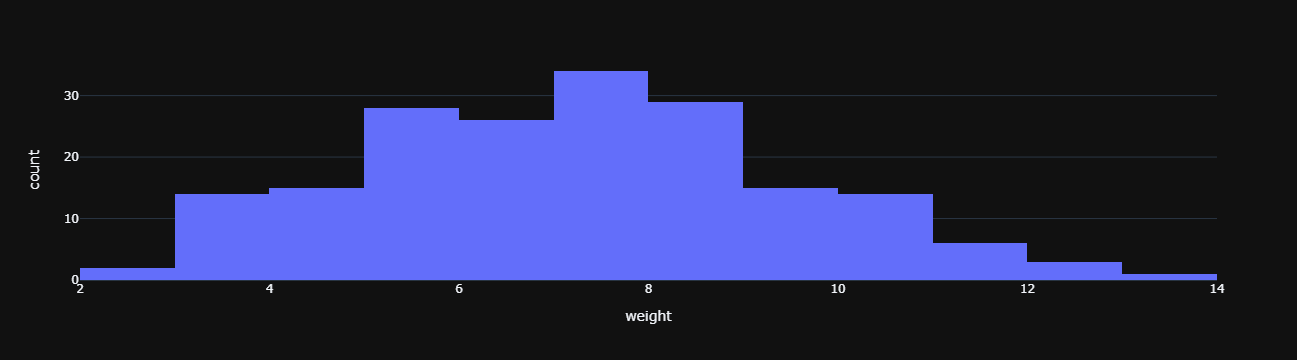

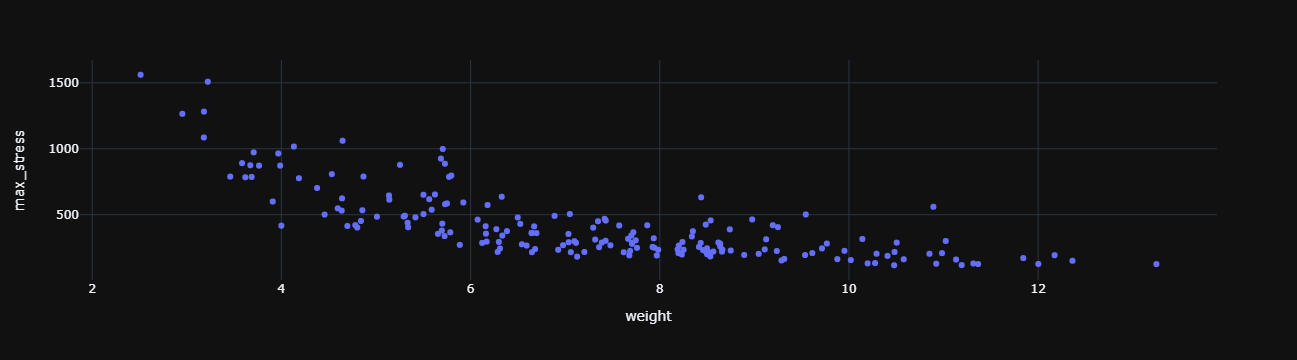

In [32]:
import plotly.express as px
fig1 = px.histogram(df, x="weight", nbins=20, template="plotly_dark")
fig1.show()
fig2 = px.scatter(df, x='weight', y='max_stress',  template="plotly_dark")
fig2.show()